# Rasgos no basados en modelos

In [59]:
from copy import deepcopy
from itertools import chain
import math
import os

import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from config import DATA_PATH, VISUALIZATIONS_PATH
from utilities import plot_stats

In [6]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "stats")
os.makedirs(FOLDER, exist_ok=True)

In [7]:
data_path = os.path.join(DATA_PATH, "session_speech.csv")

In [8]:
data = pd.read_csv(data_path)
data.columns

Index(['name', 'vote', 'senator', 'province', 'party', 'party_family',
       'speaker', 'speech', 'speech_preprocessed', 'speech_lemmas',
       'speech_pos'],
      dtype='object')

In [9]:
data.shape

(201, 11)

In [10]:
data.head(2)

,name,vote,senator,province,party,party_family,speaker,speech,speech_preprocessed,speech_lemmas,speech_pos
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,Almirón,"Hace dos años, tuvimos una sesión histórica cu...",hace dos años tuvimos una sesión histórica cua...,hacer año tener una sesión histórica cuando de...,VERB NOUN VERB DET NOUN ADJ SCONJ VERB ADP ADJ...
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN,Juntos por el cambio,Basualdo,"Gracias, señor presidente. Hoy es un día en el...",gracias señor presidente hoy es un día en el q...,gracia señor presidente hoy ser un día en el q...,NOUN NOUN NOUN ADV VERB DET NOUN ADP DET SCONJ...


In [11]:
data.vote.value_counts()

vote
positivo      111
negativo       88
abstención      1
ausente         1
Name: count, dtype: int64

In [12]:
data.speech.isna().sum()

0

In [13]:
data = data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
data.shape

(199, 11)

## Diferencia de frecuencias

Diferencia en la frecuencia absoluta de uso de palabras:

$$
y_{kw}^{(P)}-y_{kw}^{(N)}
$$

Donde k refier e al tópico, w a la palabras y P y N a los senadores que han votado positiva y negativamente, de forma respectiva.
Al considerar en este trabajo un único tópico (el aborto y su legalización), simplificamos, en este aparetado y en los siguientes:

$$
y_{w}^{(P)}-y_{w}^{(N)}
$$

El rpblema con esyte enfoque es que se ve supeditado a aquel conjunto de senadores que haya hablado más.

In [14]:
vectorizer = CountVectorizer(lowercase=True)
X = vectorizer.fit_transform(data.speech_lemmas)
X = X.toarray()
frequencies = (
    pd
    .DataFrame(
        X, columns=vectorizer.get_feature_names_out(), index=data["vote"]
    )
    .rename_axis("senator_vote", axis=0)
    .reset_index()
    .groupby("senator_vote")
    .sum()
)
frequencies

,abajo,abandonada,abandonado,abandonar,abandono,abarcar,abdominal,aber,aberración,aberrante,...,órgano,óvulo,última,últimamente,último,única,únicamente,único,útero,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,1,0,0,1,1,2,0,0,1,1,...,0,1,3,0,10,4,0,6,3,1
positivo,1,1,1,0,0,0,1,1,0,1,...,5,1,2,1,19,11,1,8,4,0


In [15]:
count_total = frequencies.sum(axis=0).apply(lambda x: math.log(x))
count_difference = frequencies.loc["positivo"]-frequencies.loc["negativo"]
count_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": count_difference,
        "pos": frequencies.loc["positivo"],
        "neg": frequencies.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
count_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,0,1,1
1,abandonada,0.000000,1,1,0
2,abandonado,0.000000,1,1,0
3,abandonar,0.000000,-1,0,1
4,abandono,0.000000,-1,0,1


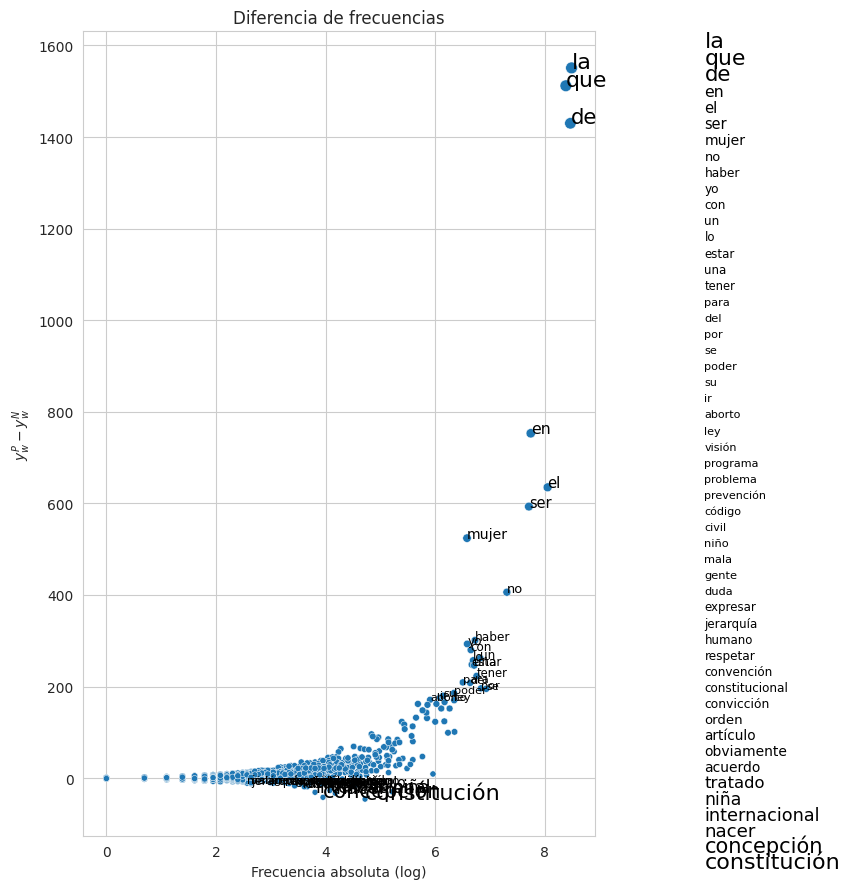

In [16]:
filename = os.path.join(FOLDER, "frecuencias.png")
plot_stats(count_diff, "Diferencia de frecuencias", "$y^{P}_{w}-y^{N}_{w}$", filename)

## Diferencia de proporciones

Se normalizan los vectores de palabras para reflejar las proporciones en lugar de su ocurrencia. La proporción observada se define como:

$$
f_{w}^{(i)} = y_{w}^{(i)} / n^{(i)}
$$

$$
f_{w}^{(P)}-f_{w}^{(N)}
$$

A diferencia del enfoque anterior, este abordaje evita el sesgo partidario basado en el volumen de los discursos.

La limitación aquí es la carencia de validez semántica, que se puede observar en el énfasis otorgado a las palabras de mayor frecuencia. Las palabras que parecen describir mejor los discursos de ambas posturas no son palabras que denoten posiciones políticas realmente sino palabras de alta frecuencia en el uso.

In [17]:
proportions = frequencies.div(frequencies.sum(axis=1), axis=0)
proportions_difference = proportions.loc["positivo"]-proportions.loc["negativo"]
proportions_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_difference,
        "pos": proportions.loc["positivo"],
        "neg": proportions.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,-0.000016,0.000019,0.000035
1,abandonada,0.000000,0.000019,0.000019,0.000000
2,abandonado,0.000000,0.000019,0.000019,0.000000
3,abandonar,0.000000,-0.000035,0.000000,0.000035
4,abandono,0.000000,-0.000035,0.000000,0.000035


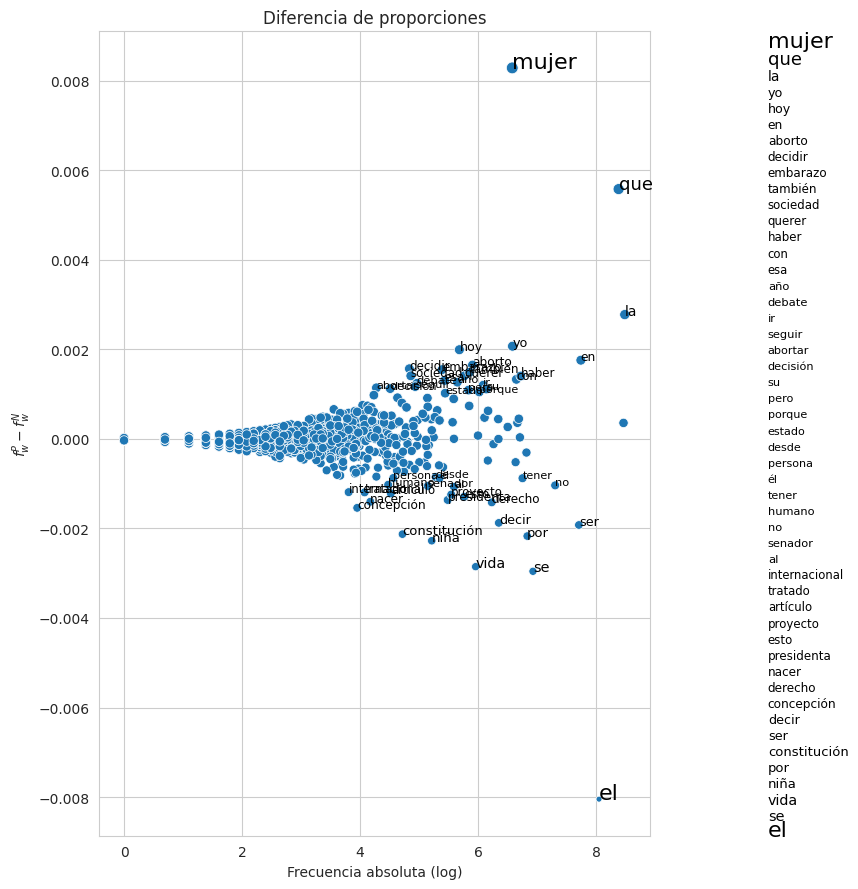

In [18]:
filename = os.path.join(FOLDER, "proporciones.png")
plot_stats(proportions_diff, "Diferencia de proporciones", "$f^{P}_{w}-f^{N}_{w}$", filename)

## Diferencia de proporciones sin stopwords

El problema del énfasis otorgado a las palabras de alta frecuencia suele intentar superarse aislando las palabras de interés y, para esto, se removuen las _stopwords_.

El problema de eliminar las _stopwords_ es que podemos terminar eliminando palabras que son significativas para el problema en cuestión (ej: "ella" en el tópico aquí abordado).

### Stopwrods de NLTK

In [33]:
nltk.download("stopwords")

from nltk.corpus import stopwords

stw = stopwords.words("spanish")
print(stw[:5])

['de', 'la', 'que', 'el', 'en']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/macarena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
print(f"Cantidad de columnas (palabras) en el dataset: {len(frequencies.columns)}")
stop = len(sorted(set(frequencies.columns).intersection(set(stw))))
print(f"Cantidad de palabras stopwords en el dataset: {stop}")
non_stop = len(sorted(set(frequencies.columns).difference(set(stw))))
print(f"Cantidad de palabras no stopwords en el dataset: {non_stop}")

Cantidad de columnas (palabras) en el dataset: 4781
Cantidad de palabras stopwords en el dataset: 73
Cantidad de palabras no stopwords en el dataset: 4708


In [21]:
columns_wo_stw = sorted(set(frequencies.columns).difference(set(stw)))
frequencies_wo_stw = frequencies[columns_wo_stw]
frequencies_wo_stw.shape

(2, 4708)

In [22]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = proportions_wo_stw.loc["positivo"]-proportions_wo_stw.loc["negativo"]
proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,-0.000030,0.000035,0.000065
1,abandonada,0.000000,0.000035,0.000035,0.000000
2,abandonado,0.000000,0.000035,0.000035,0.000000
3,abandonar,0.000000,-0.000065,0.000000,0.000065
4,abandono,0.000000,-0.000065,0.000000,0.000065


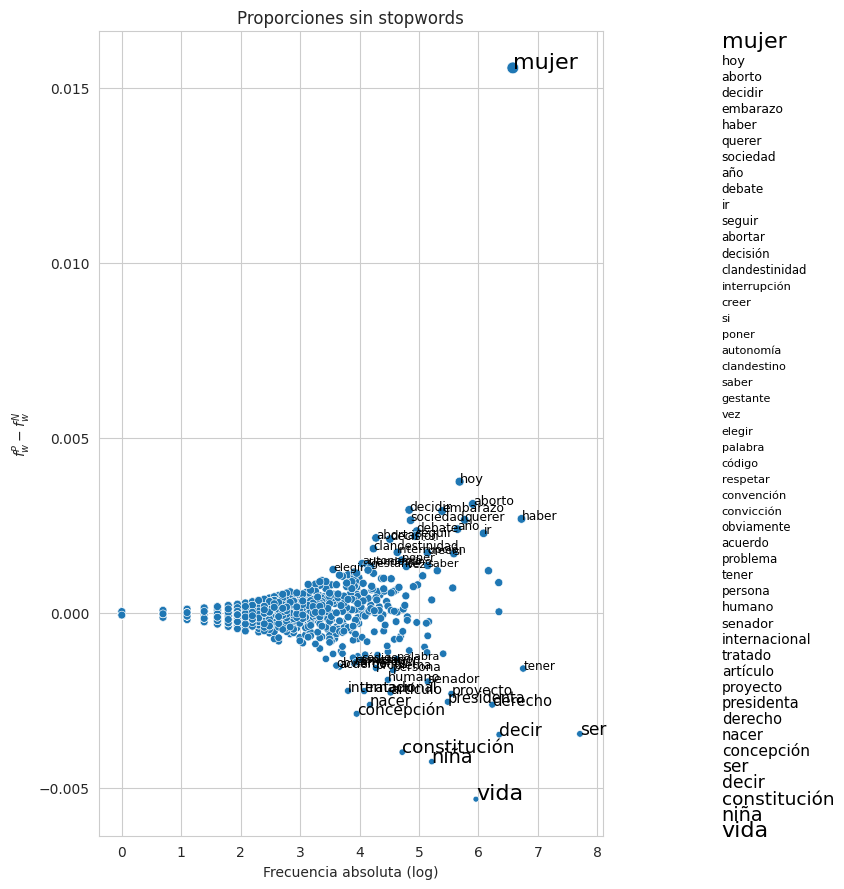

In [23]:
filename = os.path.join(FOLDER, "proporciones_sin_stopwords_nltk.png")
plot_stats(proportions_wo_stw_diff, "Proporciones sin stopwords", "$f^{P}_{w}-f^{N}_{w}$", filename)

### Stopwords por Ley de Zipf

In [25]:
filename = os.path.join(VISUALIZATIONS_PATH, "zipf_law.csv")
zipf_law = pd.read_csv(filename)
zipf_law.head()

,order,selected_lemma,selected_pos,count,raw,raw_count,log_order,log_count
0,0,la,DET,4909,"['las', 'la']","[1265, 3644]",0.000000,8.498826
1,1,de,ADP,4812,['de'],[4812],0.693147,8.478868
2,2,que,SCONJ,4465,['que'],[4465],1.098612,8.404024
3,3,el,DET,3180,"['el', 'los']","[2008, 1172]",1.386294,8.064636
4,4,y,CCONJ,2584,['y'],[2584],1.609438,7.857094


In [29]:
zipf_stw = zipf_law.loc[zipf_law.log_order<3.75, "selected_lemma"].to_list()
zipf_stw[:5]

['la', 'de', 'que', 'el', 'y']

In [30]:
print(f"Cantidad de columnas (palabras) en el dataset: {len(frequencies.columns)}")
stop = len(sorted(set(frequencies.columns).intersection(set(zipf_stw))))
print(f"Cantidad de palabras stopwords en el dataset: {stop}")
non_stop = len(sorted(set(frequencies.columns).difference(set(zipf_stw))))
print(f"Cantidad de palabras no stopwords en el dataset: {non_stop}")

Cantidad de columnas (palabras) en el dataset: 4781
Cantidad de palabras stopwords en el dataset: 39
Cantidad de palabras no stopwords en el dataset: 4742


In [31]:
columns_wo_stw = sorted(set(frequencies.columns).difference(set(zipf_stw)))
frequencies_wo_stw = frequencies[columns_wo_stw]
frequencies_wo_stw.shape

(2, 4742)

In [34]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = proportions_wo_stw.loc["positivo"]-proportions_wo_stw.loc["negativo"]
proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,-0.000031,0.000039,0.00007
1,abandonada,0.000000,0.000039,0.000039,0.00000
2,abandonado,0.000000,0.000039,0.000039,0.00000
3,abandonar,0.000000,-0.000070,0.000000,0.00007
4,abandono,0.000000,-0.000070,0.000000,0.00007


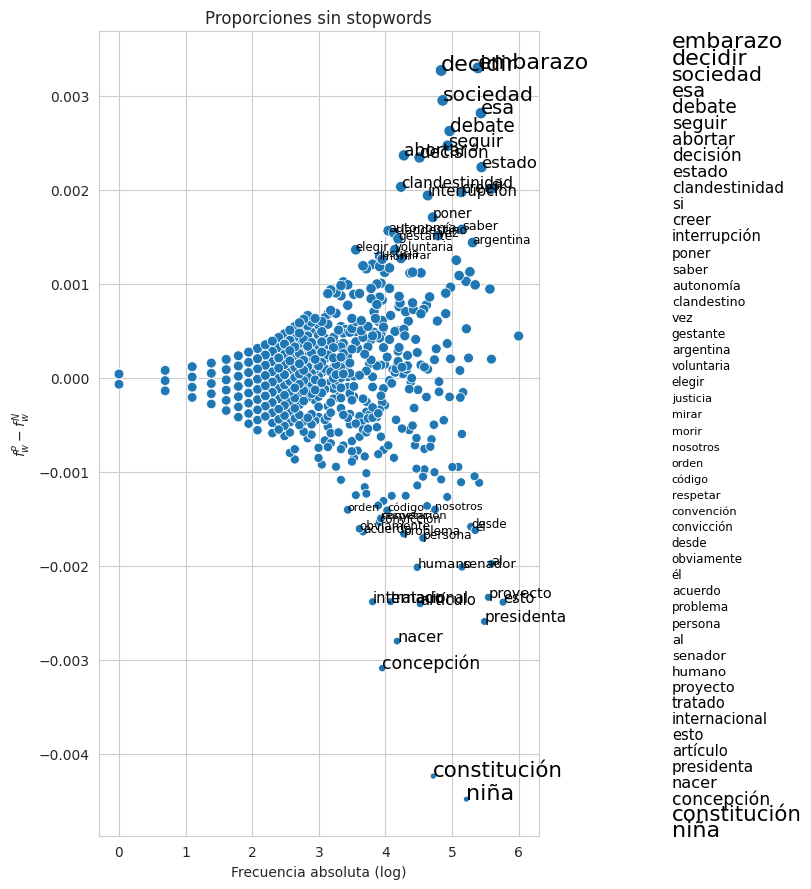

In [35]:
filename = os.path.join(FOLDER, "proporciones_sin_stopwords_zipf.png")
plot_stats(proportions_wo_stw_diff, "Proporciones sin stopwords", "$f^{P}_{w}-f^{N}_{w}$", filename)

## Odds

$$
O_{w}^{i} = \frac{f_{w}^{i}}{(1-f_{w}^{i})}
$$

$$
\theta_{w}^{(P-N)} = \frac{O_{w}^{(P)}}{O_{w}^{(N)}}
$$

In [54]:
odds_pos = proportions.loc["positivo"]/(1-proportions.loc["positivo"])
odds_neg = proportions.loc["negativo"]/(1-proportions.loc["negativo"])
odds_difference = odds_pos/odds_neg
odds_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": odds_difference,
        "pos": odds_pos,
        "neg": odds_neg
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
odds_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,0.540211,0.000019,0.000035
1,abandonada,0.000000,inf,0.000019,0.000000
2,abandonado,0.000000,inf,0.000019,0.000000
3,abandonar,0.000000,0.000000,0.000000,0.000035
4,abandono,0.000000,0.000000,0.000000,0.000035


In [55]:
odds_diff["diff"].isin([math.inf, -math.inf]).sum()

1815

In [56]:
def postprocess_odds(row):
    infs = [math.inf, -math.inf]
    if (row.pos in infs) and (row.neg in infs):
        if row.pos == row.neg:
            return 1
        else:
            return -1
    else:
        return row["diff"]

In [57]:
# remove infs to avoid ploting inf values
odds_diff_not_inf = odds_diff[~odds_diff["diff"].isin([math.inf, -math.inf])]

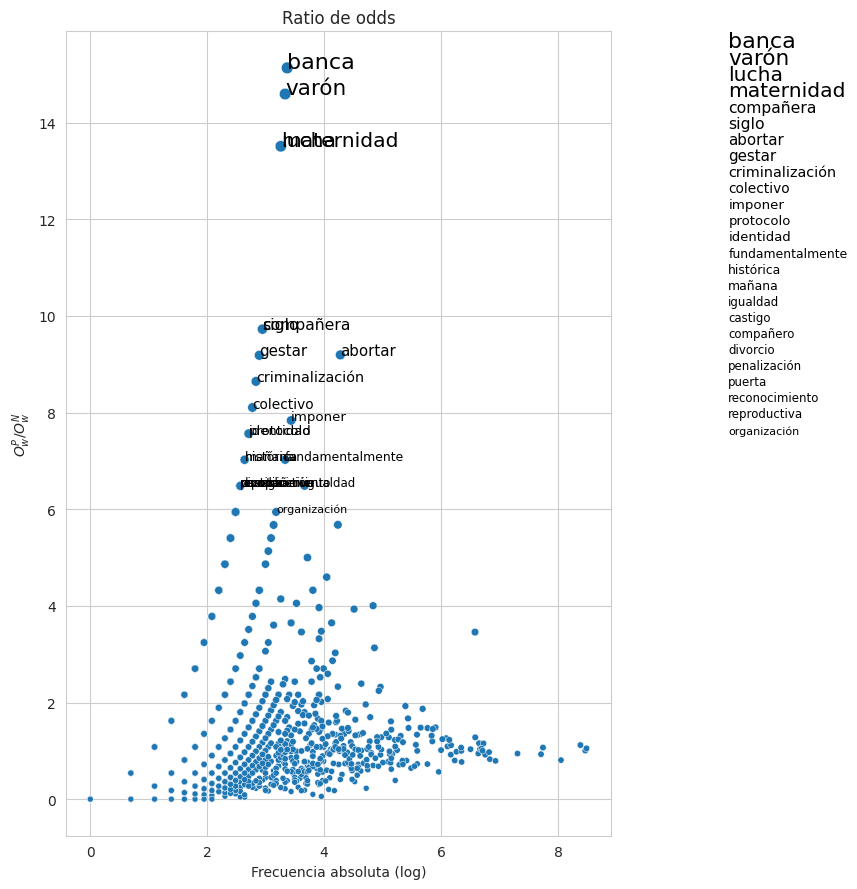

In [66]:
filename = os.path.join(FOLDER, "odds.png")
plot_stats(odds_diff_not_inf, "Ratio de odds", "$O^{P}_{w}/O^{N}_{w}$", filename)

## Log-odds-ratio

El problema de los _odds_ es que, por su asimetría, son muy difíciles de interpretar. Tomar el logaritmo del ratio permite tener una medida simétrica entre ambas posturas de votantes.

$$
\log{\bigg(\frac{O_{w}^{(P)}}{O_{w}^{(N)}}\bigg)}
$$

El problema aquí reside en qué hacer con las palabras que solo son mencionadas por una de las posturas y que, entonces, conducen a _odds_ infinitos.

In [61]:
log_odds_diff = deepcopy(odds_diff)
log_odds_diff["diff"] = np.log(log_odds_diff["diff"])
log_odds_diff.head()

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,word,total,diff,pos,neg
0,abajo,0.693147,-0.615795,0.000019,0.000035
1,abandonada,0.000000,inf,0.000019,0.000000
2,abandonado,0.000000,inf,0.000019,0.000000
3,abandonar,0.000000,-inf,0.000000,0.000035
4,abandono,0.000000,-inf,0.000000,0.000035


In [73]:
# palabras más representativas de quienes votaron a favor
(
    log_odds_diff
    .sort_values(by=["diff", "pos"], ascending=False, ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,elegir,3.555348,inf,0.000658,0.0
1,nosotras,3.178054,inf,0.000451,0.0
2,piba,3.135494,inf,0.000433,0.0
3,afirmativo,2.833213,inf,0.000320,0.0
4,década,2.833213,inf,0.000320,0.0
5,marina,2.833213,inf,0.000320,0.0
6,matrimonio,2.772589,inf,0.000301,0.0
7,definitiva,2.708050,inf,0.000282,0.0
8,violada,2.708050,inf,0.000282,0.0
9,feminista,2.639057,inf,0.000263,0.0


In [76]:
# palabras más representativas de quienes votaron a favor removiendo los =0
(
    log_odds_diff[(log_odds_diff.neg>0) & (log_odds_diff.pos>0)]
    .sort_values(by=["diff", "pos"], ascending=False, ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,banca,3.367296,2.716917,0.000527,0.000035
1,varón,3.332205,2.680531,0.000508,0.000035
2,lucha,3.258097,2.603532,0.000470,0.000035
3,maternidad,3.258097,2.603532,0.000470,0.000035
4,compañera,2.944439,2.274896,0.000338,0.000035
5,siglo,2.944439,2.274896,0.000338,0.000035
6,abortar,4.276666,2.218574,0.001280,0.000139
7,gestar,2.890372,2.217719,0.000320,0.000035
8,criminalización,2.833213,2.157076,0.000301,0.000035
9,colectivo,2.772589,2.092519,0.000282,0.000035


In [75]:
# palabras más representativas de quienes votaron en contra
(
    log_odds_diff
    .sort_values(by=["diff", "neg"], ascending=[True, False], ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,smith,2.079442,-inf,0.0,0.000278
1,universal,2.079442,-inf,0.0,0.000278
2,mera,1.945910,-inf,0.0,0.000244
3,rosatti,1.945910,-inf,0.0,0.000244
4,constitucionalista,1.791759,-inf,0.0,0.000209
5,eduardo,1.791759,-inf,0.0,0.000209
6,ende,1.791759,-inf,0.0,0.000209
7,hambre,1.791759,-inf,0.0,0.000209
8,jurar,1.791759,-inf,0.0,0.000209
9,mayoritaria,1.791759,-inf,0.0,0.000209


In [77]:
# palabras más representativas de quienes votaron en contra removiendo los =0
(
    log_odds_diff[(log_odds_diff.neg>0) & (log_odds_diff.pos>0)]
    .sort_values(by=["diff", "neg"], ascending=[True, False], ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,jerarquía,2.639057,-3.181162,0.000019,0.000453
1,mala,2.564949,-3.101084,0.000019,0.000418
2,concepción,3.951244,-2.858031,0.000094,0.001638
3,declaración,2.302585,-2.813298,0.000019,0.000313
4,científico,2.079442,-2.561914,0.000019,0.000244
5,honrar,2.079442,-2.561914,0.000019,0.000244
6,prioridad,2.079442,-2.561914,0.000019,0.000244
7,tercio,2.079442,-2.561914,0.000019,0.000244
8,visión,2.639057,-2.407918,0.000038,0.000418
9,abogado,1.945910,-2.407728,0.000019,0.000209


In [63]:
# remove infs to avoid ploting inf values
log_odds_diff_not_inf = log_odds_diff[~log_odds_diff["diff"].isin([math.inf, -math.inf])]

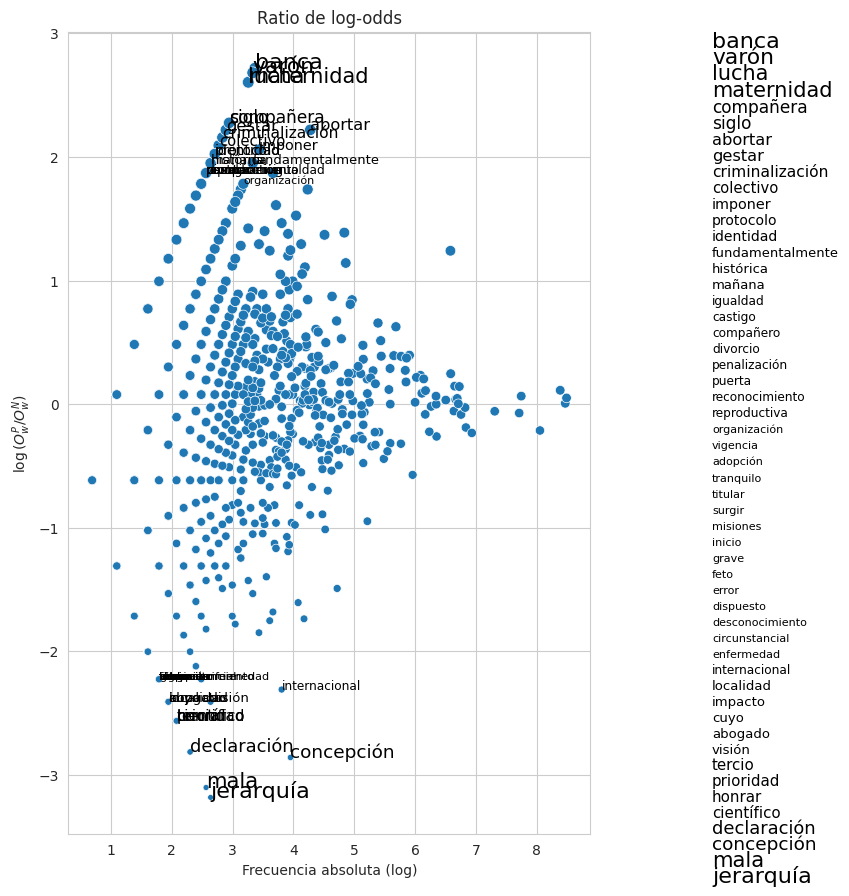

In [65]:
filename = os.path.join(FOLDER, "log_odds.png")
plot_stats(
    log_odds_diff_not_inf, "Ratio de log-odds", "$\log{(O^{P}_{w}/O^{N}_{w})}$", filename
)

### Log-odds ratio suvizado

Una opción para sobrellevar el problema de los _odds_ infinitos es agregar suavizado (por ejemplo: 0.5):
$$
\widetilde{f}^{(i)} = f^{(i)} + \varepsilon
$$

En este enfoque, el problema mayor es que las métricas se ven dominadas por los casos de palabras más oscuras o que aparecen menos.

In [104]:
smooth_log_odds_diff = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
smooth_log_odds_diff.head()

,word,total,pos,neg
0,abajo,0.693147,0.000019,0.000035
1,abandonada,0.000000,0.000019,0.000000
2,abandonado,0.000000,0.000019,0.000000
3,abandonar,0.000000,0.000000,0.000035
4,abandono,0.000000,0.000000,0.000035


In [105]:
# cantidad de palabras con frecuencia 0
(smooth_log_odds_diff[["pos", "neg"]]==0).sum(axis=0)

pos    1085
neg    1815
dtype: int64

In [106]:
smooth_log_odds_diff[["f_pos", "f_neg"]] = smooth_log_odds_diff[["pos", "neg"]].applymap(
    lambda x: x+0.5 if x == 0 else x
)
smooth_log_odds_diff.head()

,word,total,pos,neg,f_pos,f_neg
0,abajo,0.693147,0.000019,0.000035,0.000019,0.000035
1,abandonada,0.000000,0.000019,0.000000,0.000019,0.500000
2,abandonado,0.000000,0.000019,0.000000,0.000019,0.500000
3,abandonar,0.000000,0.000000,0.000035,0.500000,0.000035
4,abandono,0.000000,0.000000,0.000035,0.500000,0.000035


In [107]:
(smooth_log_odds_diff[["f_pos", "f_neg"]]==0).sum(axis=0)

f_pos    0
f_neg    0
dtype: int64

In [108]:
f_smooth_odds_pos = smooth_log_odds_diff["f_pos"]/(1-smooth_log_odds_diff["f_pos"])
f_smooth_odds_neg = smooth_log_odds_diff["f_neg"]/(1-smooth_log_odds_diff["f_neg"])
f_smooth_odds_difference = f_smooth_odds_pos/f_smooth_odds_neg
f_smooth_log_odds_diff = (
    pd
    .DataFrame({
        "word": smooth_log_odds_diff.word,
        "total": smooth_log_odds_diff.total,
        "diff": np.log(f_smooth_odds_difference),
        "pos": f_smooth_odds_pos,
        "neg": f_smooth_odds_pos
    })
)
f_smooth_log_odds_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,-0.615795,0.000019,0.000019
1,abandonada,0.000000,-10.881701,0.000019,0.000019
2,abandonado,0.000000,-10.881701,0.000019,0.000019
3,abandonar,0.000000,10.265906,1.000000,1.000000
4,abandono,0.000000,10.265906,1.000000,1.000000


/home/macarena/personal/eddc-specialization-project/notebooks/utilities.py:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


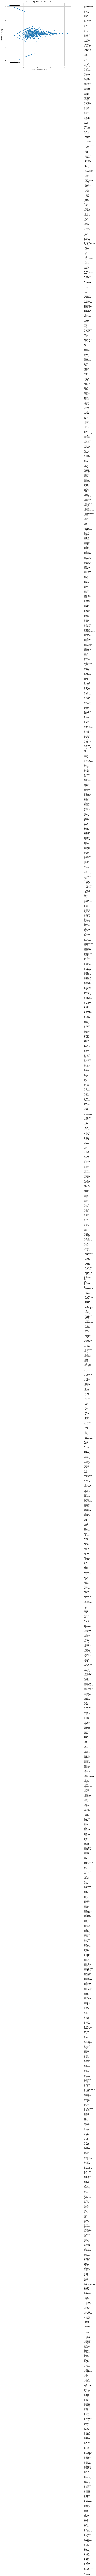

In [110]:
filename = os.path.join(FOLDER, "smooth_log_odds.png")
plot_stats(
    f_smooth_log_odds_diff, "Ratio de log-odds suavizado (0.5)", "smooth $\log{(O^{P}_{w}/O^{N}_{w})}$", filename
)

## Correction: elimating low-frequency words

In [ ]:
(
    pd.melt(
        proportions_diff[["word","pos","neg"]],
        id_vars=["word"],
        value_vars=["pos", "neg"],
    )
    .groupby("variable")["value"]
    .agg(
        min="min",
        q5=lambda x: np.percentile(x, q = 5),
        median="median",
        mean="mean",
        std="std",
        q95=lambda x: np.percentile(x, q = 95),
        max="max"
    )
)

In [ ]:
low_freq_df = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
low_freq_df.shape

In [ ]:
low_freq_df = low_freq_df[(0.000035<low_freq_df["neg"]) & (0.000019<low_freq_df["pos"])]
low_freq_df.shape

In [ ]:
low_freq_df[["pos", "neg"]].describe()

In [ ]:
high_freq_odds_pos = low_freq_df["pos"]/(1-low_freq_df["pos"])
high_freq_odds_neg = low_freq_df["neg"]/(1-low_freq_df["neg"])
high_freq_odds_difference = high_freq_odds_pos/high_freq_odds_neg
high_freq_log_odds_diff = (
    pd
    .DataFrame({
        "word": low_freq_df.word,
        "total": low_freq_df.total,
        "diff": np.log(high_freq_odds_difference),
        "pos": high_freq_odds_pos,
        "neg": high_freq_odds_neg
    })
    .reset_index(drop=True)
)
high_freq_log_odds_diff.head()

In [ ]:
perc = round(high_freq_log_odds_diff.shape[0] / proportions_diff.shape[0] * 100, 2)
print(f"Se persisten el {perc}% de los datos.")

## TF-IDF

In [ ]:
discourses = list(map(lambda x: set(x.split()),data.speech_lemmas.tolist()))
words = sorted(list(set(chain(*discourses))))

X = np.zeros((len(discourses), len(words)))

for i in range(len(words)):
    for j in range(len(discourses)):
        if words[i] in discourses[j]:
            X[j,i] += 1


In [ ]:
df = (
    pd.DataFrame(X, columns=words)
    .filter(frequencies.columns)
    .sum(axis=0)
    .to_frame()
    .rename(columns={0:"df"})
    .assign(
        idf=lambda x: 1/x,
        ln_idf=lambda x: x.idf.apply(lambda z: math.log(z))
    )
    .reset_index(names="word")
)
df.head()


In [ ]:
# al final uso df sin ln porque muchas palabras ocurren solo en un documento y eso
# hace que su peso termine siendo 0
tf_idf = (
    proportions
    .T
    .rename_axis("", axis=1)
    .reset_index(names="word")
    .merge(df, on="word")
    .assign(
        pos=lambda x: x.positivo/(x.df),
        neg=lambda x: x.negativo/(x.df)
    )
)
tf_idf.head()

In [ ]:
tfidf_diff = (
    pd
    .DataFrame({
        "word": tf_idf["word"],
        "diff": tf_idf["pos"]-tf_idf["neg"],
        "pos": tf_idf["pos"],
        "neg": tf_idf["neg"]
    })
    .merge(count_diff[["word", "total"]], on="word")
)
tfidf_diff.head()

In [ ]:
corr_prop = tfidf_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

## WordScores

In [ ]:
wkw = (
    (proportions.loc["positivo"]-proportions.loc["negativo"])/
    (proportions.loc["positivo"]+proportions.loc["negativo"])
)
nkw = frequencies.sum(axis=0) / frequencies.sum().sum()

wkw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": wkw*nkw,
        "wkw": wkw,
        "nkw": nkw,
        "wnkw": wkw*nkw
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
wkw_diff.head()

In [ ]:
corr_prop = wkw_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

## Visualizations

In [ ]:
stats = [high_freq_log_odds_diff,tfidf_diff, wkw_diff]
titles = ["Log-osdds-ratio suavizado (remoción de p. con baja frec.)", "TF-IDF", "WordScores"]
y_labels = ["smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$", "$tfidf^{P}_{kw}-tfidf^{N}_{kw}$", "$W^{*(D-R)}_{kw}$"]

Observaciones:

- en freq. abs. casi no hay palabras negativas, esto puede ser porque:
  - los neg hablaron menos (personas)
  - los neg tienen discursos más breves
  - los neg no usaron palabras que se distingan de pos (en términos de freq. abs.)
  - ... seguir explorando